Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import gcd
#import latexify

Square Lattice

The following class provides supports for simulating Anderson localization and the Hofstader model on a finite square lattice with periodic boundary conditions. The possible outputs are a plot of the eigenvalue spectrum, an eigenvector from the middle of the spectrum, the participation ratio, and the Hofstader butterfly. 

An interesting result to note is that the presence of disorder (it doesn't matter what the physical cause of it may be) kills the butterfly fractal. This idea is introduced in: cite Bhatt

In [20]:
class Square_Hamiltonian:
    """ Square lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float):
        self.L = length  # Set hamiltonian dimensions
        self.matrix = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)  # Initialize hamiltonian matrix
        self.disorder = disorder  # Set disorder parameter
        self.t = t # Set hopping amplitude
        self.phi = phi # Set magnetic field parameter

    def disorder_setter(self, i):
        # Incorporate the disorder parameter into matrix elements
        eps_i = self.disorder * (2 * np.random.rand() - 1)  # Random on-site energy
        self.matrix[i, i] = eps_i

    def hamiltonian_setter(self, i, j, phi=None):
        n = i * self.L + j
        # Vertical hopping
        m = ((i + 1) % self.L) * self.L + j
        self.matrix[n, m] = self.t

        # Horizontal hopping
        m = i * self.L + (j + 1) % self.L

        B = np.exp(1j * 2 * np.pi * (self.phi if phi is None else phi) * i)
        self.matrix[n, m] = B * self.t

        if self.disorder != 0:
            self.disorder_setter(n)


    def construct_matrix(self, phi=None):
        # We want to iterate through i and j
        for i, j in np.ndindex((self.L, self.L)):
            self.hamiltonian_setter(i, j, phi)

        if self.phi != 0:
            self.H = (self.matrix + self.matrix.T.conj()) / 2 # symmetrize
        else:
            self.H = self.matrix + self.matrix.T  # symmetrize
        print(self.H)
        self.evals, self.evecs = np.linalg.eigh(self.H)  # calculate eigenvalues and eigenvectors

    """ basic plotting functions """

    def plot_evals(self):
        # Plot eigenvalues of hamiltonian matrix
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        # Plot an eigenvector
        self.psi = self.evecs[:,self.L//2] # Some eigenvector in the middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        # Plot an eigenvector supposing disorder exists
        self.psi = self.evecs[:,self.L//2] 
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0) # 'evecs' is a matrix of $\psi_i(x)$ amplitudes, 1st axis is x. This does the sum over x.
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """

    # Plot the Hofstadter butterfly

    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for p in range(1, self.L + 1):
          for q in range(1, self.L + 1):
              if q > p and gcd(p, q) == 1:
                  nphi = p / q
                  self.construct_matrix(phi = nphi) # Rebuild hamiltonian for each (p,q)
                  # Plot each energy level for the given phi
                  plt.plot(np.full_like(self.evals, nphi), self.evals, 'o', c="black", markersize=0.1)

        # Plot title and labels
        plt.xlabel(r'$\phi$', fontsize=15)
        plt.ylabel(r'$E$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $L=' + str(self.L) + '$', fontsize=15)
        plt.grid()
        plt.show()


[[ 0. +0.00000000e+00j  0.5+0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0.5+0.00000000e+00j  0. +0.00000000e+00j  0.5+0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0. +0.00000000e+00j  0.5+0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 ...
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j -0.5-6.37249622e-15j  0. +0.00000000e+00j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
  -0.5+6.37249622e-15j  0. +0.00000000e+00j -0.5-6.37249622e-15j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j -0.5+6.37249622e-15j  0. +0.00000000e+00j]]


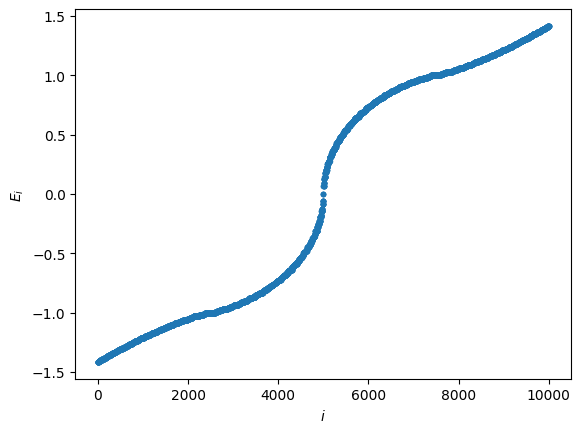

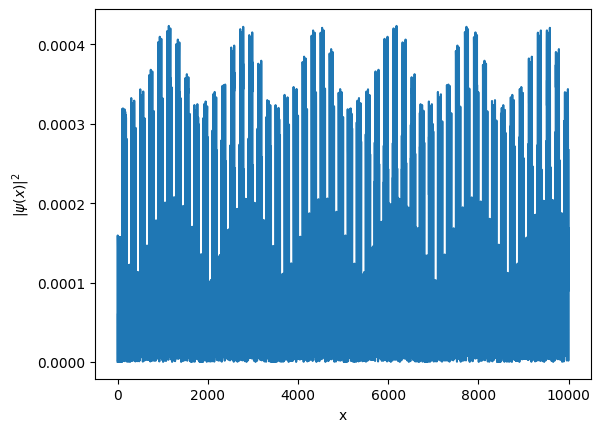

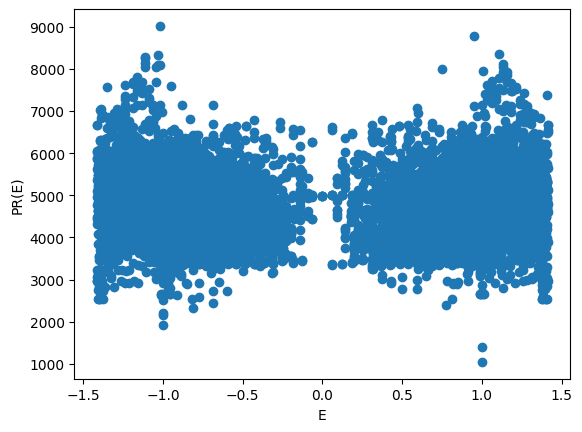


[[ 0. +0.00000000e+00j  0.5+0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0.5+0.00000000e+00j  0. +0.00000000e+00j  0.5+0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 [ 0. +0.00000000e+00j  0.5+0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j]
 ...
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j -0.5-6.37249622e-15j  0. +0.00000000e+00j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
  -0.5+6.37249622e-15j  0. +0.00000000e+00j -0.5-6.37249622e-15j]
 [ 0. +0.00000000e+00j  0. +0.00000000e+00j  0. +0.00000000e+00j ...
   0. +0.00000000e+00j -0.5+6.37249622e-15j  0. +0.00000000e+00j]]


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

In [25]:
# example 1 - no disorder, phi = 1/2, L = 10
square = Square_Hamiltonian(length=100 , t=1.0, disorder=0. , phi= 0.5)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec()
print()
square.plot_pr()
print()
square.plot_butterfly()

[[ 0.06724549+0.0000000e+00j  0.5       +0.0000000e+00j
   0.        +0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 [ 0.5       +0.0000000e+00j  0.01926037+0.0000000e+00j
   0.5       +0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 [ 0.        +0.0000000e+00j  0.5       +0.0000000e+00j
   0.09598847+0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 ...
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ...  0.06946908+0.0000000e+00j
  -0.5       +5.5109106e-16j  0.        +0.0000000e+00j]
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ... -0.5       -5.5109106e-16j
  -0.02861789+0.0000000e+00j -0.5       +5.5109106e-16j]
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ...  0.        +0.0000000e+00j
  -0.5       -

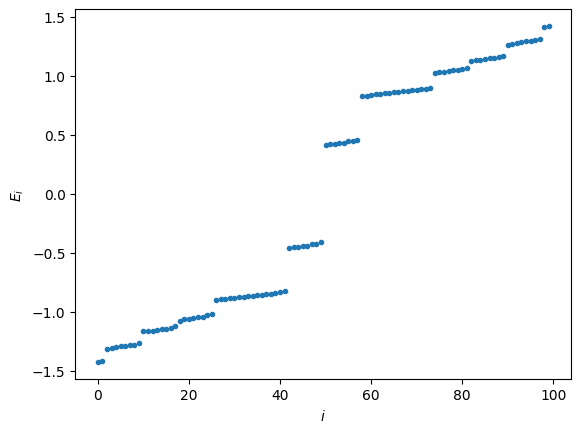

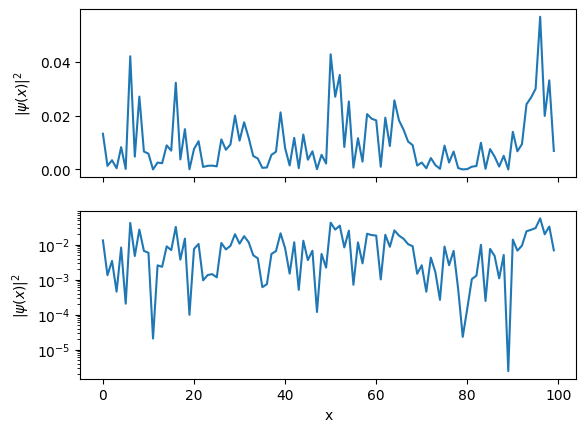

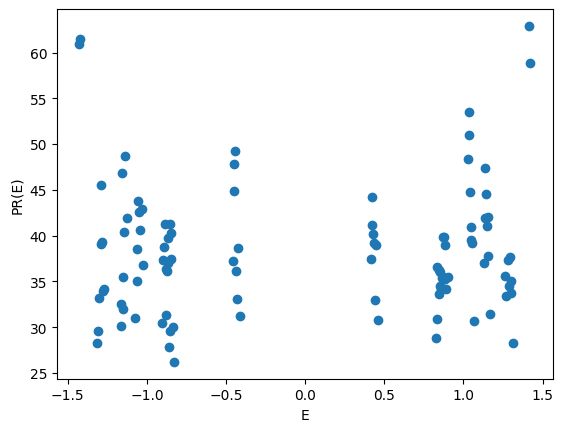


[[-0.09160471+0.0000000e+00j  0.5       +0.0000000e+00j
   0.        +0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 [ 0.5       +0.0000000e+00j  0.06424995+0.0000000e+00j
   0.5       +0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 [ 0.        +0.0000000e+00j  0.5       +0.0000000e+00j
   0.04421677+0.0000000e+00j ...  0.        +0.0000000e+00j
   0.        +0.0000000e+00j  0.        +0.0000000e+00j]
 ...
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ... -0.0488757 +0.0000000e+00j
  -0.5       +5.5109106e-16j  0.        +0.0000000e+00j]
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ... -0.5       -5.5109106e-16j
   0.01773964+0.0000000e+00j -0.5       +5.5109106e-16j]
 [ 0.        +0.0000000e+00j  0.        +0.0000000e+00j
   0.        +0.0000000e+00j ...  0.        +0.0000000e+00j
  -0.5       

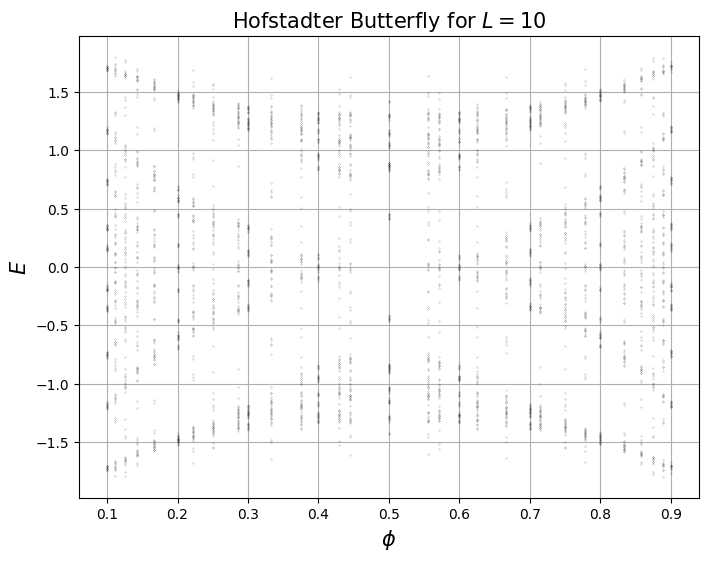

In [22]:
# example 2 - W - 0.1, phi = 1/2, L = 10
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.1 , phi= 0.5)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec_disorder()
print()
square.plot_pr()
print()
square.plot_butterfly()

Honeycomb Lattice

In [23]:
class honeycomb_Hamiltonian:
    """ Honeycomb lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float):
        self.L = length  # Set hamiltonian dimensions
        self.matrix = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)  # Initialize hamiltonian matrix
        self.disorder = disorder  # Set disorder parameter
        self.t = t # Set hopping amplitude
        self.phi = phi # Set magnetic field parameter
        # the AA and BB blocks should be zeros unless there are different on-site potentials
        self.AA = np.zeros((self.L, self.L), dtype= complex) # AA block
        self.BB = np.zeros((self.L, self.L), dtype= complex) # BB block

    def disorder_setter(self, i):
        # Incorporate the disorder parameter into matrix elements
        eps_i = self.disorder * (2 * np.random.rand() - 1)  # Random on-site energy
        self.AB[i, i] = eps_i

    def AB_block(self):
        self.AB = np.zeros((self.L, self.L), dtype= complex) # initialize AB
        for i, j in np.ndindex((self.L, self.L)):
       # Vertical hopping: Connect (i, j) to (i + 1, j) if (i + j) % 2 == 0
       # (ie. if the sum of indices is even since the remainder is zero)
            if (i + j) % 2 == 0:
                m = (i + 1) % self.L
                self.AB[i, j] = self.t

           # Horizontal hopping: Connect (i, j) to (i, j + 1)
            m = (j + 1) % self.L
            self.AB[i, m] = self.t


           # Apply phase factor for magnetic flux
            if j < self.L - 1:  # Only apply phase if not on the last column
                B = np.exp(1j * 2 * np.pi * (self.phi) * i)
                self.AB[i, m] *= B  # Correct phase application

            if self.disorder != 0:
                self.disorder_setter(i)

        return self.AB


    def BA_block(self):
        return self.AB_block().T.conjugate()

    def construct_matrix(self):
        # In this case, we want to combine the blocks to form the hamiltonian
        self.AB = self.AB_block()
        self.BA = self.BA_block()
        # construct complete hamiltonian using the four blocks

        self.upper = np.concatenate((self.AA, self.AB), axis=1)
        self.lower = np.concatenate((self.BA, self.BB), axis=1)
        self.H = np.concatenate((self.upper, self.lower), axis=0)
        self.evals, self.evecs = np.linalg.eigh(self.H)  # calculate eigenvalues and eigenvectors

    """ basic plotting functions """

    def plot_evals(self):
        # Plot eigenvalues of hamiltonian matrix
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        # Plot an eigenvector
        self.psi = self.evecs[:,self.L//2] # Some eigenvector in the middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        # Plot an eigenvector supposing disorder exists
        self.psi = self.evecs[:,self.L//2] 
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0) 
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """

    # Plotting the butterfly
    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for p in range(1, self.L + 1):
            for q in range(p + 1, self.L + 1):
                if gcd(p, q) == 1:
                    nphi = p / q
                    self.phi = nphi  # Set magnetic flux
                    self.construct_matrix()  # Rebuild Hamiltonian for each (p,q)
                    # Plot each energy level for the given phi
                    plt.plot(np.full_like(self.evals, nphi), self.evals,'o', c="black", markersize=0.5)

        # Plot title and labels
        plt.xlabel(r'$\phi$', fontsize=15)
        plt.ylabel(r'$E$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $L=' + str(self.L) + '$', fontsize=15)
        plt.grid()
        plt.show()


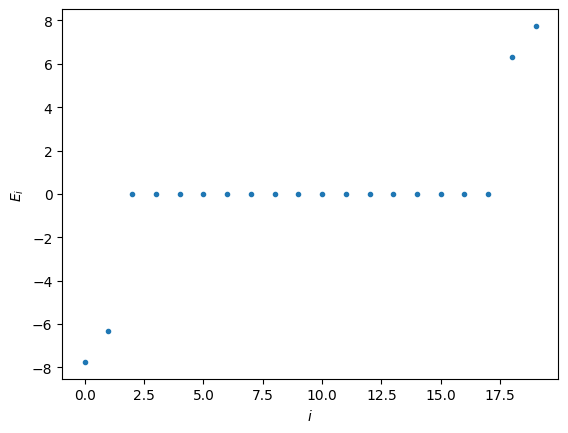

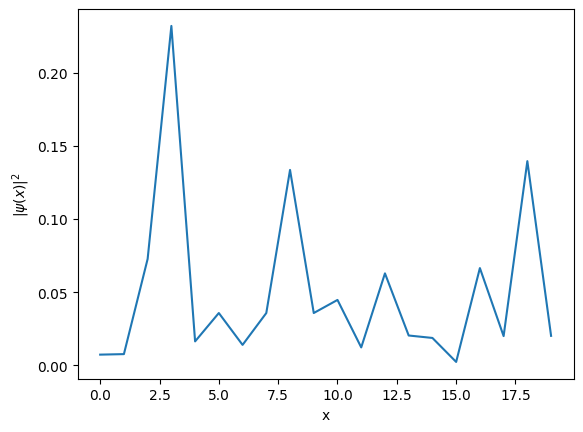

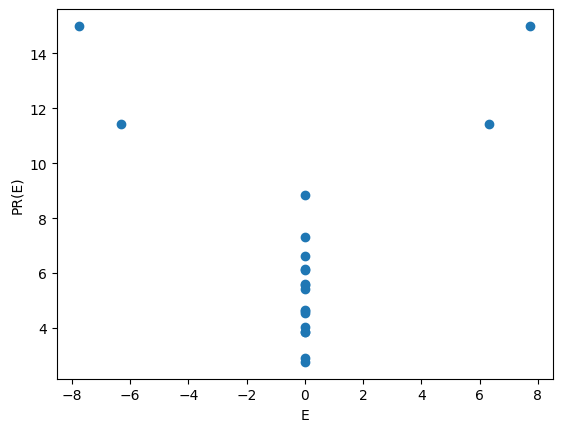

<bound method honeycomb_Hamiltonian.plot_butterfly of <__main__.honeycomb_Hamiltonian object at 0x1121b1a60>>

In [24]:
# example 1 - repeated for honeycomb
honeycomb = honeycomb_Hamiltonian(length=10 , t=1.0, disorder=0. , phi= 0.5)
honeycomb.construct_matrix()
honeycomb.plot_evals()
print()
honeycomb.plot_evec()
print()
honeycomb.plot_pr()
print()
honeycomb.plot_butterfly

Triangular Lattice

In [38]:
class Triangular_Hamiltonian:
    """ Triangular lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float):
        self.L = length  # Set hamiltonian dimensions
        self.matrix = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)  # Initialize hamiltonian matrix
        self.disorder = disorder  # Set disorder parameter
        self.t = t  # Set hopping amplitude
        self.phi = phi  # Set magnetic field parameter

    def disorder_setter(self, i):
        # Incorporate the disorder parameter into matrix elements
        eps_i = self.disorder * (2 * np.random.rand() - 1)  # Random on-site energy
        self.matrix[i, i] = eps_i

    def hamiltonian_setter(self, i, j, phi=None):
        n = i * self.L + j

        # Vertical hopping (up)
        m = ((i + 1) % self.L) * self.L + j
        self.matrix[n, m] = self.t

        # Diagonal hopping (up-right)
        m = ((i + 1) % self.L) * self.L + ((j + 1) % self.L)
        B1 = np.exp(1j * 2 * np.pi * (self.phi if phi is None else phi) * i)
        self.matrix[n, m] = B1 * self.t

        # Horizontal hopping (right)
        m = i * self.L + ((j + 1) % self.L)
        B2 = np.exp(1j * 2 * np.pi * (self.phi if phi is None else phi) * i)
        self.matrix[n, m] = B2 * self.t

        if self.disorder != 0:
            self.disorder_setter(n)

    def construct_matrix(self, phi=None):
        # Iterate through all lattice points
        for i, j in np.ndindex((self.L, self.L)):
            self.hamiltonian_setter(i, j, phi)

        # Symmetrize the matrix
        if self.phi != 0:
            self.H = (self.matrix + self.matrix.T.conj()) / 2
        else:
            self.H = self.matrix + self.matrix.T

        # Calculate eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ basic plotting functions """

    def plot_evals(self):
        # Plot eigenvalues of hamiltonian matrix
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        # Plot an eigenvector
        self.psi = self.evecs[:,self.L//2]  # Some eigenvector in the middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        # Plot an eigenvector supposing disorder exists
        self.psi = self.evecs[:,self.L//2] 
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0)  # Participation ratio calculation
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """

    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for p in range(1, self.L + 1):
            for q in range(1, self.L + 1):
                if q > p and gcd(p, q) == 1:
                    nphi = p / q
                    self.construct_matrix(phi=nphi)  # Rebuild hamiltonian for each (p,q)
                    # Plot each energy level for the given phi
                    plt.plot(np.full_like(self.evals, nphi), self.evals, 'o', 
                            c="black", markersize=0.1)

        # Plot title and labels
        plt.xlabel(r'$\phi$', fontsize=15)
        plt.ylabel(r'$E$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $L=' + str(self.L) + '$', fontsize=15)
        plt.grid()
        plt.show()

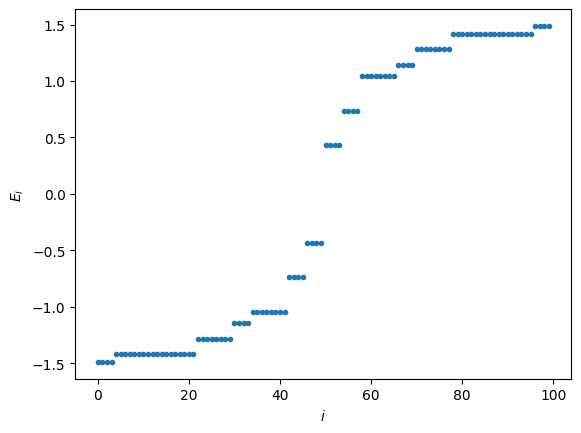

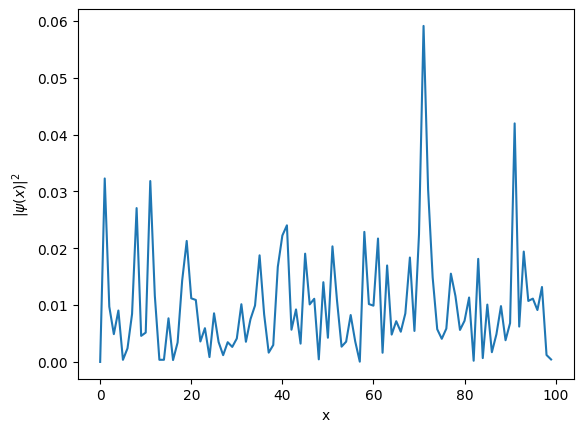

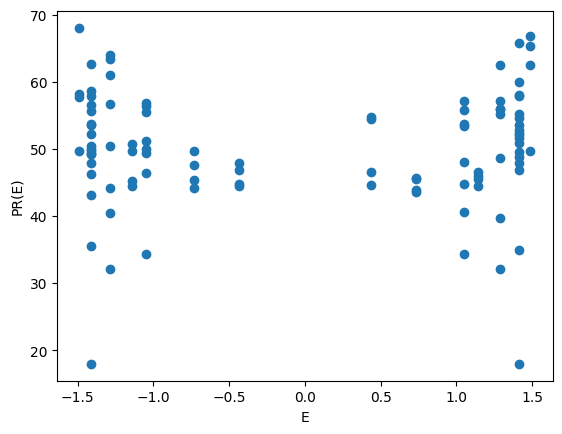

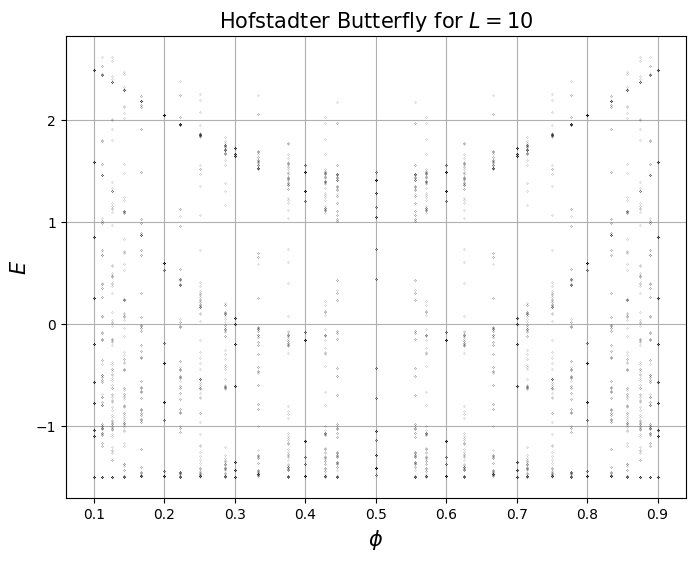

In [39]:
# Example 1 - repeated for triangular lattice
triangular = Triangular_Hamiltonian(length=10, t=1.0, disorder=0.0, phi=0.5)
triangular.construct_matrix()
triangular.plot_evals()
triangular.plot_evec()
triangular.plot_pr()
triangular.plot_butterfly()

Kagome Lattice

In [4]:
class Kagome_Hamiltonian:
    """ Kagome lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float):
        self.L = length  # Set hamiltonian dimensions
        # For Kagome lattice, we need 3 sites per unit cell
        self.matrix = np.zeros((3 * self.L * self.L, 3 * self.L * self.L), dtype=complex)
        self.disorder = disorder  # Set disorder parameter
        self.t = t  # Set hopping amplitude
        self.phi = phi  # Set magnetic field parameter

        # Initialize the block matrices for the 3x3 structure
        self.AA = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.BB = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.CC = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.AB = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.BC = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)
        self.CA = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)

    def disorder_setter(self, block, i):
        # Incorporate the disorder parameter into matrix elements for each sublattice
        eps_i = self.disorder * (2 * np.random.rand() - 1)
        block[i, i] = eps_i

    def construct_blocks(self, phi=None):
        phi_use = self.phi if phi is None else phi

        for i, j in np.ndindex((self.L, self.L)):
            idx = i * self.L + j

            # Nearest neighbor connections between sublattices
            # A to B connections
            if j < self.L - 1:
                self.AB[idx, idx + 1] = self.t
            if i < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.AB[idx, idx + self.L] = self.t * phase

            # B to C connections
            if j < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.BC[idx, idx + 1] = self.t * phase
            if i < self.L - 1:
                self.BC[idx, idx + self.L] = self.t

            # C to A connections (completing the triangle)
            if j < self.L - 1:
                self.CA[idx, idx + 1] = self.t
            if i < self.L - 1:
                phase = np.exp(1j * 2 * np.pi * phi_use * i)
                self.CA[idx, idx + self.L] = self.t * phase

            # Add disorder if specified
            if self.disorder != 0:
                self.disorder_setter(self.AA, idx)
                self.disorder_setter(self.BB, idx)
                self.disorder_setter(self.CC, idx)

    def construct_matrix(self, phi=None):
        # Construct the block matrices
        self.construct_blocks(phi)

        # Combine blocks into full Hamiltonian
        top = np.concatenate((self.AA, self.AB, self.CA.conjugate()), axis=1)
        middle = np.concatenate((self.AB.conjugate(), self.BB, self.BC), axis=1)
        bottom = np.concatenate((self.CA, self.BC.conjugate(), self.CC), axis=1)

        self.H = np.concatenate((top, middle, bottom), axis=0)

        # Ensure Hermiticity
        self.H = (self.H + self.H.conjugate().T) / 2

        # Calculate eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ basic plotting functions """

    def plot_evals(self):
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        self.psi = self.evecs[:,3*self.L//2]  # Middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        self.psi = self.evecs[:,3*self.L//2]
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0)
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """

    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for p in range(1, self.L + 1):
            for q in range(1, self.L + 1):
                if q > p and gcd(p, q) == 1:
                    nphi = p / q
                    self.construct_matrix(phi=nphi)
                    plt.plot(np.full_like(self.evals, nphi), self.evals, 'o',
                            c="black", markersize=0.1)

        plt.xlabel(r'$\phi$', fontsize=15)
        plt.ylabel(r'$E$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $L=' + str(self.L) + '$', fontsize=15)
        plt.grid()
        plt.show()

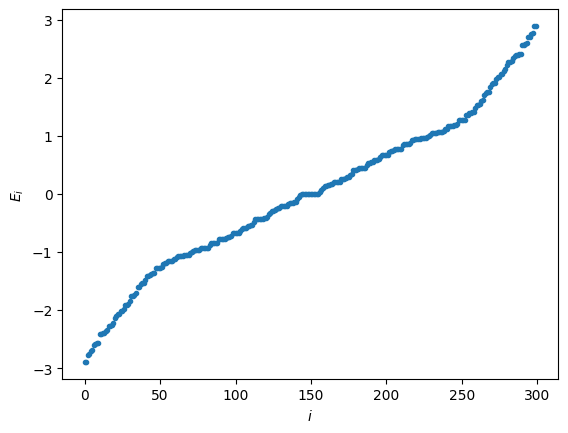

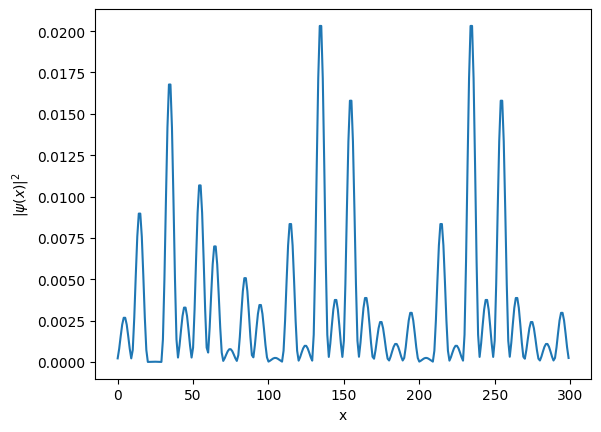

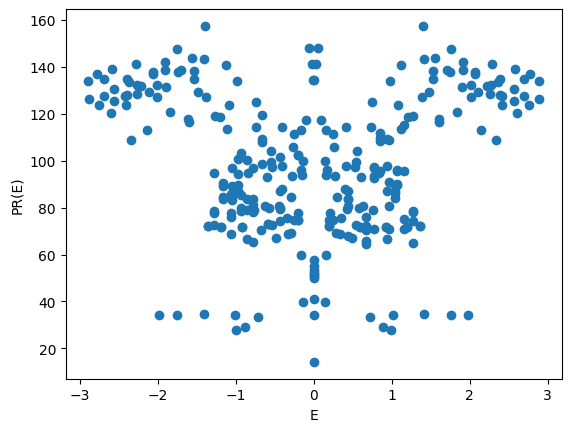

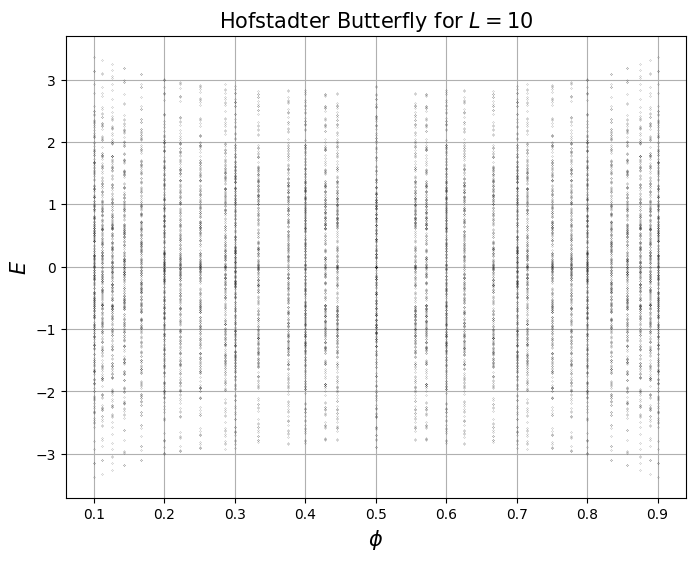

In [5]:
# Example 1 - repeated for kagome lattice
kagome = Kagome_Hamiltonian(length=10, t=1.0, disorder=0.0, phi=0.5)
kagome.construct_matrix()
kagome.plot_evals()
kagome.plot_evec()
kagome.plot_pr()
kagome.plot_butterfly()

Oblique Lattice 